посилання на colab -> https://colab.research.google.com/drive/1nxgVQ8ZjyRPm1upp8j4WxViUb6sb83iN?usp=sharing

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

from tensorflow.keras.layers import (Input, Rescaling, RandomFlip, RandomRotation, RandomContrast,
                                     Conv2D, BatchNormalization, MaxPool2D,
                                     GlobalAveragePooling2D, Dense, Dropout)

from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import TopKCategoricalAccuracy

In [2]:
# Шлях до директорії з тренувальними зображеннями
train_images_dir = './Train'

# Списки для зображень і міток
images = []
labels = []

# Проходимо по кожній папці (класу)
for class_folder in os.listdir(train_images_dir):
    class_folder_path = os.path.join(train_images_dir, class_folder)

    # Перевіряємо, чи є це папка, і якщо так, то зберігаємо зображення
    if os.path.isdir(class_folder_path):
        for image_file in os.listdir(class_folder_path):
            # Створення шляху до зображення
            img_path = os.path.join(class_folder_path, image_file)
            # Завантаження зображення
            img = image.load_img(img_path, target_size=(32, 32))  # зміна розміру на 32x32
            img_array = image.img_to_array(img)

            # Додаємо зображення в список
            images.append(img_array)
            # Додаємо мітку класу (число)
            labels.append(int(class_folder))

# Перетворюємо списки у NumPy масиви
images = np.array(images)
labels = np.array(labels)

# Перевірка форми даних
print(f"Форма зображень: {images.shape}")
print(f"Мітки класів: {labels.shape}")

Форма зображень: (39209, 32, 32, 3)
Мітки класів: (39209,)


In [3]:
# Поділ на тренувальні та тестові дані
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"Розмір тренувальних даних: {X_train.shape}")
print(f"Розмір тестових даних: {X_test.shape}")

Розмір тренувальних даних: (31367, 32, 32, 3)
Розмір тестових даних: (7842, 32, 32, 3)


In [4]:
# Перетворення міток на one-hot encoding
y_train = to_categorical(y_train, num_classes=43)
y_test = to_categorical(y_test, num_classes=43)

print(f"Форма y_train після перетворення: {y_train.shape}")
print(f"Форма y_test після перетворення: {y_test.shape}")

Форма y_train після перетворення: (31367, 43)
Форма y_test після перетворення: (7842, 43)


In [5]:
height, width, channels = 32, 32, 3
NUM_CATEGORIES = 43  # Кількість класів для GTSRB

# Створення моделі
model = Sequential([
    Input(shape=(height, width, channels)),

    # Нормалізація + аугментації
    Rescaling(1./255),
    RandomFlip("horizontal"),
    RandomRotation(0.05),
    RandomContrast(0.1),

    # Блок 1
    Conv2D(32, (3,3), padding="same", activation="relu"),
    BatchNormalization(),
    Conv2D(32, (3,3), padding="same", activation="relu"),
    BatchNormalization(),
    MaxPool2D(),

    # Блок 2
    Conv2D(64, (3,3), padding="same", activation="relu"),
    BatchNormalization(),
    Conv2D(64, (3,3), padding="same", activation="relu"),
    BatchNormalization(),
    MaxPool2D(),

    # Блок 3
    Conv2D(128, (3,3), padding="same", activation="relu", kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    MaxPool2D(),

    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(128, activation="relu"),
    Dropout(0.3),
    Dense(NUM_CATEGORIES, activation="softmax")
])

In [6]:
LOSS = CategoricalCrossentropy()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss=LOSS,
    metrics=[
        "accuracy",
        TopKCategoricalAccuracy(k=3, name="top3")
    ]
)

cb = [
    tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=8, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1)
]

In [8]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),  # щоб працював val_accuracy і val_loss
    epochs=20, # змненено з 50 на 20 для швидшого навчання
    batch_size=64, # змненено з 32 на 64 для швидшого навчання
    shuffle=True,
    callbacks=cb,
    verbose=1
)

Epoch 1/20
491/491 ━━━━━━━━━━━━━━━━━━━━ 30s 60ms/step - accuracy: 0.4685 - loss: 1.7271 - top3: 0.7155 - val_accuracy: 0.6785 - val_loss: 1.2552 - val_top3: 0.8629 - learning_rate: 3.0000e-04
Epoch 2/20
491/491 ━━━━━━━━━━━━━━━━━━━━ 30s 61ms/step - accuracy: 0.6142 - loss: 1.2461 - top3: 0.8375 - val_accuracy: 0.7911 - val_loss: 0.7801 - val_top3: 0.9410 - learning_rate: 3.0000e-04
Epoch 3/20
491/491 ━━━━━━━━━━━━━━━━━━━━ 30s 61ms/step - accuracy: 0.7235 - loss: 0.8940 - top3: 0.9119 - val_accuracy: 0.8688 - val_loss: 0.4689 - val_top3: 0.9792 - learning_rate: 3.0000e-04
Epoch 4/20
491/491 ━━━━━━━━━━━━━━━━━━━━ 30s 62ms/step - accuracy: 0.7947 - loss: 0.6574 - top3: 0.9488 - val_accuracy: 0.9111 - val_loss: 0.3143 - val_top3: 0.9908 - learning_rate: 3.0000e-04
Epoch 5/20
491/491 ━━━━━━━━━━━━━━━━━━━━ 30s 61ms/step - accuracy: 0.8409 - loss: 0.5097 - top3: 0.9674 - val_accuracy: 0.9338 - val_loss: 0.2495 - val_top3: 0.9940 - learning_rate: 3.0000e-04
Epoch 6/20
491/491 ━━━━━━━━━━━━━━━━━━━━ 

In [9]:
training_accuracy = history.history["accuracy"]
training_loss = history.history["loss"]
validation_accuracy = history.history["val_accuracy"]
validation_loss = history.history["val_loss"]

print(f"Максимальна точність на тренувальних даних: {max(training_accuracy):.4f}")
print(f"Максимальна точність на валідаційних даних: {max(validation_accuracy):.4f}")

Максимальна точність на тренувальних даних: 0.9705
Максимальна точність на валідаційних даних: 0.9912


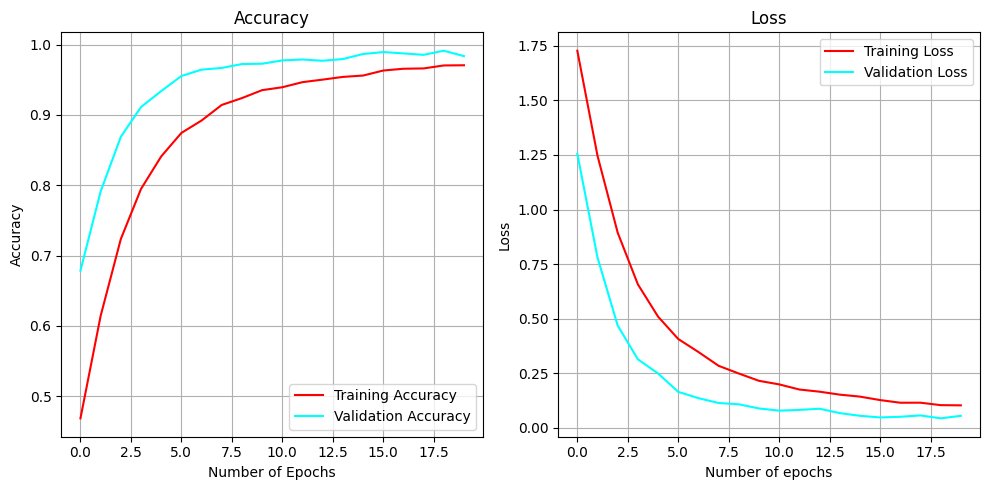

In [10]:
plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.plot(training_accuracy, color = "red", label = "Training Accuracy")
plt.plot(validation_accuracy, color = "cyan", label = "Validation Accuracy")
plt.legend()
plt.grid(True)
plt.title("Accuracy")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(training_loss, color = "red", label = "Training Loss")
plt.plot(validation_loss, color = "cyan", label = "Validation Loss")
plt.grid(True)
plt.legend()
plt.title("Loss")
plt.xlabel("Number of epochs")
plt.ylabel("Loss")

plt.tight_layout()
plt.show()

246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


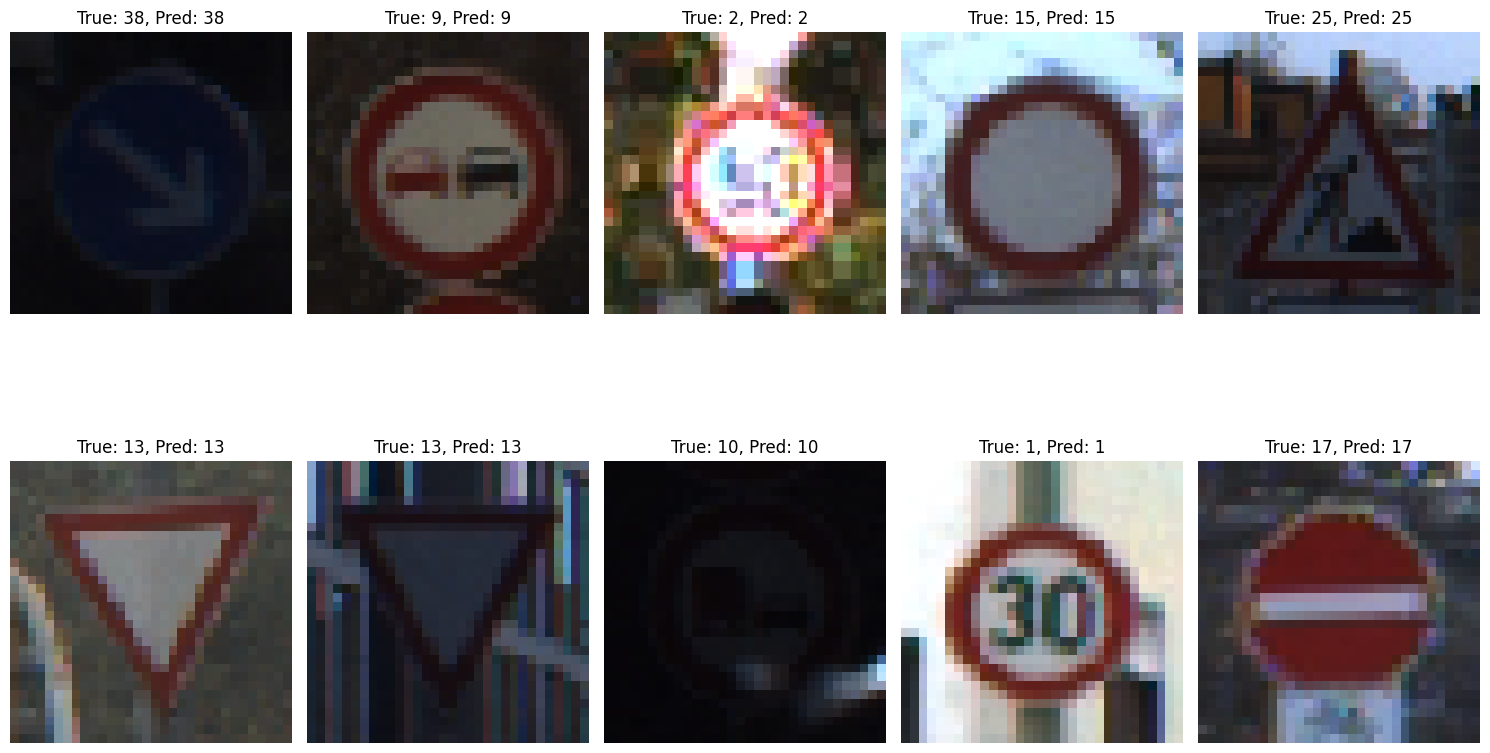

In [12]:
random_indices = np.random.choice(len(X_test), size=10, replace=False)

# Прогнозування класів для тестових даних
y_pred = model.predict(X_test)

# Виведення зображень та їхніх прогнозованих і справжніх класів
plt.figure(figsize=(15, 10))
for i, idx in enumerate(random_indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_test[idx].astype("uint8")) # Показуємо зображення
    plt.axis('off')

    true_class = np.argmax(y_test[idx])  # Справжній клас
    predicted_class = np.argmax(y_pred[idx])  # Прогнозований клас

    plt.title(f"True: {true_class}, Pred: {predicted_class}")

plt.tight_layout()
plt.show()

ВИСНОВКИ.
У цій роботі було розроблено та навчено згорткову нейронну мережу для класифікації дорожніх знаків за допомогою набору даних GTSRB. Було виконано попередня обробка даних, включаючи зміну розміру зображень, нормалізацію та аугментацію, що допомогло покращити загальну продуктивність моделі. Архітектура моделі включала кілька згорткових шарів, шарів нормалізації та шарів підвибірки, що дозволило ефективно витягувати ознаки з вхідних зображень.